# Analyse bivariée : génération, allégeance, alliances, décorations

Pour l'importation des données, voir ces carnets sparqlbook:
* [All data on WW1 Aces](C:\UniNe\Master année 1\semestre 2\Les-as-de-la-Grande-Guerre-\sparqlbooks\asWW1_wikidata_import_population.sparqlbook)


Pour vérifier l'ensemble des informations disponibles, voir ce carnet sparqlbook:
* [Information disponible](C:\UniNe\Master année 1\semestre 2\Les-as-de-la-Grande-Guerre-\sparqlbooks\asWW1_wikidata_explore_population.sparqlbook )




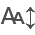

In [2]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

### Module de visualisation de données
#  https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)




In [3]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [4]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [5]:
## define SPARQL enpoint
endpoint = "https://ag1gha303ygjmx4r.allegrograph.cloud/repositories/As-de-la-Guerre"

In [6]:
query = """
PREFIX wdt:  <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#>

SELECT ?ace
       (SAMPLE(?label) AS ?aceLabel)
       (SAMPLE(?allegLabel) AS ?allegiance)
       (COUNT(DISTINCT ?award) AS ?nbAwards)
       (SAMPLE(?year) AS ?birthYear)
WHERE {
  GRAPH <https://github.com/samohTDNM/as-ww1/blob/main/docs/wikidata-import.md> {
    ?ace rdfs:label ?label .
    ?ace wdt:P945 ?alleg .
    ?alleg rdfs:label ?allegLabel .

    OPTIONAL { ?ace wdt:P166 ?award }
    OPTIONAL { 
      ?ace wdt:P569 ?birthDate .
      BIND(xsd:integer(SUBSTR(STR(?birthDate), 1, 4)) AS ?year)
    }
  }
}
GROUP BY ?ace
ORDER BY ?birthYear

"""

In [7]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [8]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

957


[['http://www.wikidata.org/entity/Q6225085',
  'John Capper',
  'United Kingdom of Great Britain and Ireland',
  '2',
  '1861'],
 ['http://www.wikidata.org/entity/Q3724015',
  'Emanuele Vittorio Parodi',
  'Kingdom of Italy',
  '0',
  '1862'],
 ['http://www.wikidata.org/entity/Q57569',
  'Prince Henry of Prussia',
  'Germany',
  '11',
  '1862']]

In [9]:
### Créer un DataFrame à partir du résultat
qr = spqf.get_json_sparql_result(endpoint, query)
r = [l for l in spqf.sparql_result_to_list(qr)]

df = pd.DataFrame(r)
df.columns = ["aceUri", "aceLabel", "allegiance", "nbAwards","birthYear"]

# Variable binaire
df["hasAward"] = df["nbAwards"].astype(int).apply(lambda x: "Oui" if x > 0 else "Non")
df.head()


,aceUri,aceLabel,allegiance,nbAwards,birthYear,hasAward
0,http://www.wikidata.org/entity/Q6225085,John Capper,United Kingdom of Great Britain and Ireland,2,1861,Oui
1,http://www.wikidata.org/entity/Q3724015,Emanuele Vittorio Parodi,Kingdom of Italy,0,1862,Non
2,http://www.wikidata.org/entity/Q57569,Prince Henry of Prussia,Germany,11,1862,Oui
3,http://www.wikidata.org/entity/Q193236,Gabriele D'Annunzio,Kingdom of Italy,7,1863,Oui
4,http://www.wikidata.org/entity/Q1337203,Emile Reymond,France,2,1865,Oui


In [10]:
### Inspecter la structure du dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   aceUri      957 non-null    object
 1   aceLabel    957 non-null    object
 2   allegiance  957 non-null    object
 3   nbAwards    957 non-null    object
 4   birthYear   957 non-null    object
 5   hasAward    957 non-null    object
dtypes: object(6)
memory usage: 45.0+ KB


In [11]:
### Store to CSV
f_path = r"C:\UniNe\Master année 1\semestre 2\Les-as-de-la-Grande-Guerre-\data\df_aces_allegiances_awards.csv"
df.to_csv(f_path, index=False, encoding="utf-8")
print(f"Dataset saved at: {f_path}")


Dataset saved at: C:\UniNe\Master année 1\semestre 2\Les-as-de-la-Grande-Guerre-\data\df_aces_allegiances_awards.csv


## Coder les deux groupes de belligérants (Alliés vs. Pouvoirs centraux) et leur distribution 

In [12]:
### Inspecter les données : premiers enregistrements des allégeances
print(df.iloc[:5, :]["allegiance"])

0    United Kingdom of Great Britain and Ireland
1                               Kingdom of Italy
2                                        Germany
3                               Kingdom of Italy
4                                         France
Name: allegiance, dtype: object


In [13]:
### Regrouper les effectifs par allégeance
df_allegiance = df.groupby("allegiance").size()  
df_allegiance = pd.DataFrame(df_allegiance, columns=["effectif"])  
df_allegiance = df_allegiance.sort_values("effectif", ascending=False)

print(df_allegiance.head(25))  # afficher les 25 premières lignes



                                             effectif
allegiance                                           
France                                            255
United States                                     118
Kingdom of Italy                                  117
United Kingdom of Great Britain and Ireland       102
Poland                                             57
Australia                                          44
Germany                                            37
Canada                                             35
German Empire                                      34
Russian Empire                                     28
United Kingdom                                     19
Austria–Hungary                                    15
German Reich                                       14
Belgium                                             9
New Zealand                                         7
Second Polish Republic                              6
Italy                       

In [ ]:
### En premier lieu, on nettoit les données de bases pour éviter les doublons (tels que "Kingdom of Italy" et "Italy")

df["allegiance_clean_map"] = df["allegiance"].str.strip() # on normalise l'affichage
allegiance_clean_map = {
    # Italy
    "Kingdom of Italy": "Italy",
    "Italy": "Italy",

    # UK and dominions
    "United Kingdom of Great Britain and Ireland": "United Kingdom",
    "United Kingdom": "United Kingdom",
    "British Empire": "United Kingdom",

    # Germany
    "Germany": "Germany",
    "German Empire": "Germany",
    "German Reich": "Germany",
    "Nazi Germany": "Germany",

    # Austria-Hungary
    "Austria-Hungary": "Austria-Hungary",
    "Austria–Hungary": "Austria-Hungary",  # en-dash version
    "Austria": "Austria-Hungary",

    # Poland
    "Second Polish Republic": "Poland",

    # Romania
    "Kingdom of Romania": "Romania",

    # Hungary
    "Kingdom of Hungary": "Hungary",
    "Hungary": "Hungary",

    # Russia
    "Russian Empire": "Russia",
    "Soviet Union": "Russia",
}


In [15]:
## Fonction de nettoyage de l'Alliance
df["allegiance_clean"] = df["allegiance"].replace(allegiance_clean_map)

# Vérifier la distribution après nettoyage
df_allegiance_clean = df.groupby("allegiance_clean").size().reset_index(name="effectif")
df_allegiance_clean = df_allegiance_clean.sort_values("effectif", ascending=False)

print(df_allegiance_clean.head(30))

      allegiance_clean  effectif
10              France       255
31      United Kingdom       125
15               Italy       122
32       United States       118
11             Germany        86
24              Poland        63
1            Australia        44
6               Canada        35
27              Russia        30
2      Austria-Hungary        19
3              Belgium         9
21         New Zealand         7
5             Bulgaria         5
13             Hungary         4
29        South Africa         4
26             Romania         4
23      Ottoman Empire         3
14             Ireland         3
30              Sweden         2
25            Portugal         2
22              Norway         2
18  Kingdom of Prussia         2
0            Argentina         1
4               Brazil         1
7                Chile         1
8           Costa Rica         1
9       Czechoslovakia         1
17  Kingdom of Bavaria         1
16               Japan         1
12        

In [16]:
### Créer une fonction de codage des blocs d'allégeance, dans le doute, la Pologne est écartée
def codeAlliances(allegiance_clean):
    # alliés durant 14-18
    allies = [
        "France",
        "Italy",
        "United States", "United Kingdom of Great Britain and Ireland",
        "United Kingdom",
        "Australia", "Canada", "New Zealand",
        "Belgium", "Russian Empire", "South Africa", "Ireland", "Portugal", "Romania", "Serbia", "Russia"
    ]
    
    # Pouvoirs centraux durant 14-18
    central_powers = [
        'Germany', 'German Empire', 'German Reich', 'Nazi Germany',
        'Austria-Hungary', 'Austria',
        'Bulgaria', 'Ottoman Empire', 'Kingdom of Saxony', 'Kingdom of Prussia', 'Hungary', 'Kingdom of Bavaria'
    ]
    
    if allegiance_clean in allies:
        return 'Allies'
    elif allegiance_clean in central_powers:
        return 'Central Powers'
    else:
        return 'Autre'  


In [17]:
### Tester la fonction
print(codeAlliances('Italy'))

Allies


In [18]:
# on test pour classifier l'allégeance
df["allianceBlock"] = df.apply(lambda x: codeAlliances(x["allegiance_clean"]), axis=1)
df.head(3)


,aceUri,aceLabel,allegiance,nbAwards,birthYear,hasAward,allegiance_clean,allianceBlock
0,http://www.wikidata.org/entity/Q6225085,John Capper,United Kingdom of Great Britain and Ireland,2,1861,Oui,United Kingdom,Allies
1,http://www.wikidata.org/entity/Q3724015,Emanuele Vittorio Parodi,Kingdom of Italy,0,1862,Non,Italy,Allies
2,http://www.wikidata.org/entity/Q57569,Prince Henry of Prussia,Germany,11,1862,Oui,Germany,Central Powers


In [19]:
### Regrouper et compter
df_allianceBlock = df.groupby('allianceBlock').size()
df_allianceBlock = pd.DataFrame(df_allianceBlock.sort_values(ascending=True))
df_allianceBlock.columns = ['effectif']

print(df_allianceBlock)



                effectif
allianceBlock           
Autre                 77
Central Powers       121
Allies               759


In [20]:
### How to handle data about Poles
df[df['allegiance'].str.contains('Poland', case=False, na=False)]


,aceUri,aceLabel,allegiance,nbAwards,birthYear,hasAward,allegiance_clean,allianceBlock
226,http://www.wikidata.org/entity/Q84730463,Władysław Dittmer,Poland,1,1888,Oui,Poland,Autre
234,http://www.wikidata.org/entity/Q87460570,Bolesław Lepszy,Poland,1,1888,Oui,Poland,Autre
301,http://www.wikidata.org/entity/Q28653897,Jan Kieżun,Poland,5,1890,Oui,Poland,Autre
309,http://www.wikidata.org/entity/Q96048921,Juliusz Gilewicz,Poland,6,1890,Oui,Poland,Autre
313,http://www.wikidata.org/entity/Q87412993,Jan Röder,Poland,3,1890,Oui,Poland,Autre
326,http://www.wikidata.org/entity/Q85437749,Władysław Popiel,Poland,2,1891,Oui,Poland,Autre
338,http://www.wikidata.org/entity/Q11725502,Jerzy Szeruda,Poland,0,1891,Non,Poland,Autre
368,http://www.wikidata.org/entity/Q87775784,Bolesław Gallus,Poland,3,1891,Oui,Poland,Autre
404,http://www.wikidata.org/entity/Q87208718,Antoni Poznański,Poland,1,1892,Oui,Poland,Autre
408,http://www.wikidata.org/entity/Q94012602,Adam Dziembowski,Poland,1,1892,Oui,Poland,Autre


In [21]:
 ### Regrouper et compter les personnes issues de Pologne
df_poland = (
    df[df['allegiance_clean'].str.contains('Poland', case=False, na=False)]
    .groupby('allianceBlock')
    .size()
)

df_poland = pd.DataFrame(df_poland.sort_values(ascending=True))
df_poland.columns = ['effectif']

print(df_poland)

               effectif
allianceBlock          
Autre                63


In [22]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df['allianceBlock'] = df['allegiance_clean'].apply(codeAlliances)
df.iloc[97:101, :]


,aceUri,aceLabel,allegiance,nbAwards,birthYear,hasAward,allegiance_clean,allianceBlock
97,http://www.wikidata.org/entity/Q527442,Jan Olieslagers,Belgium,3,1883,Oui,Belgium,Allies
98,http://www.wikidata.org/entity/Q2758259,Joseph Vuillemin,France,11,1883,Oui,France,Allies
99,http://www.wikidata.org/entity/Q3298883,Mathieu Tenant de la Tour,France,2,1883,Oui,France,Allies
100,http://www.wikidata.org/entity/Q715184,Louis Paulhan,France,3,1883,Oui,France,Allies


In [23]:
# regarder les personnes à certains index
df.iloc[111:118][["aceLabel","allegiance","allegiance_clean","allianceBlock"]]


,aceLabel,allegiance,allegiance_clean,allianceBlock
111,Amédée Thubé,France,France,Allies
112,Jacques Moureaux,France,France,Allies
113,John Cyril Porte,Ireland,Ireland,Allies
114,Franco Scarioni,Kingdom of Italy,Italy,Allies
115,Bentfield Hucks,United Kingdom of Great Britain and Ireland,United Kingdom,Allies
116,Henry Petre,United Kingdom of Great Britain and Ireland,United Kingdom,Allies
117,Orazio Pierozzi,Kingdom of Italy,Italy,Allies


### Distribution des allégeance et des alliances: représentation graphique

In [24]:
### Regrouper et compter par allégeance
df_alleg = df.groupby('allegiance_clean').size()
df_alleg = pd.DataFrame(df_alleg.sort_values(ascending=False))
df_alleg.columns = ['effectif']

# Ajouter une colonne fréquence (%)
df_alleg['frequence'] = (100 * df_alleg['effectif'] / df_alleg['effectif'].sum()).round(2)

df_alleg




,effectif,frequence
allegiance_clean,,
France,255,26.65
United Kingdom,125,13.06
Italy,122,12.75
United States,118,12.33
Germany,86,8.99
Poland,63,6.58
Australia,44,4.60
Canada,35,3.66
Russia,30,3.13


In [25]:
ljt = pd.DataFrame(df_alleg['frequence'].sort_values(ascending=False)).T
ljt


allegiance_clean,France,United Kingdom,Italy,United States,Germany,Poland,Australia,Canada,Russia,Austria-Hungary,...,Costa Rica,Czechoslovakia,Kingdom of Bavaria,Japan,Greece,Kingdom of Saxony,Mexico,Serbia,Venezuela,Wales
frequence,26.65,13.06,12.75,12.33,8.99,6.58,4.6,3.66,3.13,1.99,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [26]:
### Définir les couleurs en fonction des alliances (le pays aurait été trop complexe)
col_palette = {
    "Allies": "#4682B4",         # Steel Blue
    "Central Powers": "#CD5C5C", # Indian Red
    "Others": "#DCDCDC"          # Gainsboro
}



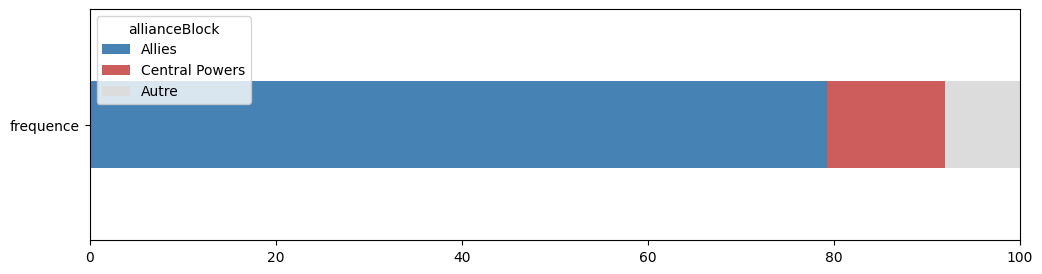

In [27]:


### Pandas plot reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
## Barplots
# https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

df_block = df.groupby('allianceBlock').size()
df_block = pd.DataFrame(df_block.sort_values(ascending=False))
df_block.columns = ['effectif']

# 2. Calculate frequencies (%)
df_block['frequence'] = (100 * df_block['effectif'] / df_block['effectif'].sum()).round(2)

ljt = pd.DataFrame(df_block['frequence']).T

col_palette = [
    "#4682B4",  
    "#CD5C5C",  
    "#DCDCDC"   
]

fig = ljt.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 3),
    color=col_palette,
    width=0.3,
    xlim=[0, 100]
)


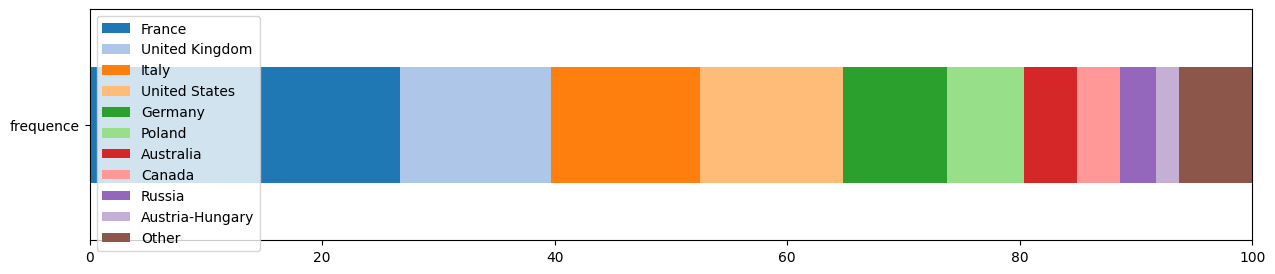

In [28]:
### Regrouper et compter par allégeance
df_alleg = df.groupby('allegiance_clean').size()
df_alleg = pd.DataFrame(df_alleg.sort_values(ascending=False))
df_alleg.columns = ['effectif']

# Ajouter une colonne fréquence (%)
df_alleg['frequence'] = (100 * df_alleg['effectif'] / df_alleg['effectif'].sum()).round(2)

### Garder seulement les 10 premiers + fusionner le reste
topN = 10
df_top = df_alleg.head(topN).copy()
df_other = pd.DataFrame({
    'effectif': [df_alleg.iloc[topN:]['effectif'].sum()],
    'frequence': [df_alleg.iloc[topN:]['frequence'].sum()]
}, index=['Other'])

df_final = pd.concat([df_top, df_other])

ljt = pd.DataFrame(df_final['frequence']).T

### color palette simple
col_palette = plt.cm.tab20.colors[:len(ljt.columns)]

### Tracer
fig = ljt.plot(
    kind='barh',
    stacked=True,
    figsize=(15,3),
    color=col_palette,
    width=0.5,
    xlim=[0,100]
)

### Codage par période de cinq ans

In [29]:
### Créer une liste d'années pour séparer en périodes de 5 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_5 = list(range(1860, 1930, 5))
print(l_5[:5],l_5[-5:], len(l_5)-1)

[1860, 1865, 1870, 1875, 1880] [1905, 1910, 1915, 1920, 1925] 13


In [30]:
### Transformer les années de naissance en entiers
df.birthYear = df.birthYear.apply(lambda x : int(x))

In [31]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df['per_5'] = pd.cut(df['birthYear'], l_5, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df['per_5'] = df['per_5'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df.head(3)

,aceUri,aceLabel,allegiance,nbAwards,birthYear,hasAward,allegiance_clean,allianceBlock,per_5
0,http://www.wikidata.org/entity/Q6225085,John Capper,United Kingdom of Great Britain and Ireland,2,1861,Oui,United Kingdom,Allies,1860-1864
1,http://www.wikidata.org/entity/Q3724015,Emanuele Vittorio Parodi,Kingdom of Italy,0,1862,Non,Italy,Allies,1860-1864
2,http://www.wikidata.org/entity/Q57569,Prince Henry of Prussia,Germany,11,1862,Oui,Germany,Central Powers,1860-1864


In [32]:
### distribution des naissances par périodes de 5 ans
naissances_per = df.groupby(by='per_5', observed=True).size()
print(naissances_per)

per_5
1860-1864      4
1865-1869      9
1870-1874     11
1875-1879     31
1880-1884     68
1885-1889    148
1890-1894    347
1895-1899    327
1900-1904     12
dtype: int64


### Comparer période et allégeance

In [33]:
### Tableau de contingence : allégeance vs génération (par 5 ans)
X = "allegiance_clean"
Y = "per_5"  

ddf = df[[X, Y]].pivot_table(
    index=Y,
    columns=X,
    observed=True,
    aggfunc=len,
    margins=True,
    margins_name="Total"
).fillna(0).astype(int)

ddf



allegiance_clean,Argentina,Australia,Austria-Hungary,Belgium,Brazil,Bulgaria,Canada,Chile,Costa Rica,Czechoslovakia,...,Romania,Russia,Serbia,South Africa,Sweden,United Kingdom,United States,Venezuela,Wales,Total
per_5,,,,,,,,,,,,,,,,,,,,,
1860-1864,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,4
1865-1869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,1,0,0,9
1870-1874,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,11
1875-1879,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,5,4,0,0,31
1880-1884,1,0,0,1,1,0,0,0,0,0,...,0,2,0,0,0,13,3,0,0,68
1885-1889,0,4,5,2,0,2,3,0,0,0,...,1,4,0,0,1,17,22,1,0,148
1890-1894,0,23,10,4,0,2,14,0,1,1,...,3,15,1,3,1,28,37,0,1,347
1895-1899,0,17,4,2,0,1,18,0,0,0,...,0,9,0,1,0,57,48,0,0,327
1900-1904,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,3,0,0,12


In [34]:
### On prend le top 10 dans l'ordre décroissant
top10 = (
    ddf.loc["Total"]        
    .drop("Total")          
    .sort_values(ascending=False)  
    .head(10)              
    .index.tolist()         
)
ddf_top10 = ddf[top10 + ["Total"]]

ddf_top10

allegiance_clean,France,United Kingdom,Italy,United States,Germany,Poland,Australia,Canada,Russia,Austria-Hungary,Total
per_5,,,,,,,,,,,
1860-1864,0,1,2,0,1,0,0,0,0,0,4
1865-1869,3,2,1,1,1,0,0,0,0,0,9
1870-1874,7,1,2,0,0,0,0,0,0,0,11
1875-1879,16,5,1,4,3,0,0,0,0,0,31
1880-1884,32,13,10,3,0,0,0,0,2,0,68
1885-1889,47,17,14,22,18,2,4,3,4,5,148
1890-1894,89,28,51,37,34,22,23,14,15,10,347
1895-1899,59,57,38,48,28,37,17,18,9,4,327
1900-1904,2,1,3,3,1,2,0,0,0,0,12


In [35]:
# Palette pour les 10 principales allégeances
col_palette_top10 = {
    "France": "#1f77b4",           # bleu
    "United Kingdom": "#ff7f0e",   # orange
    "Italy": "#2ca02c",            # vert
    "United States": "#d62728",    # rouge
    "Germany": "#9467bd",          # violet
    "Poland": "#8c564b",           # brun
    "Australia": "#e377c2",        # rose
    "Canada": "#7f7f7f",           # gris
    "Russia": "#bcbd22",           # olive
    "Austria-Hungary": "#17becf",  # turquoise
}



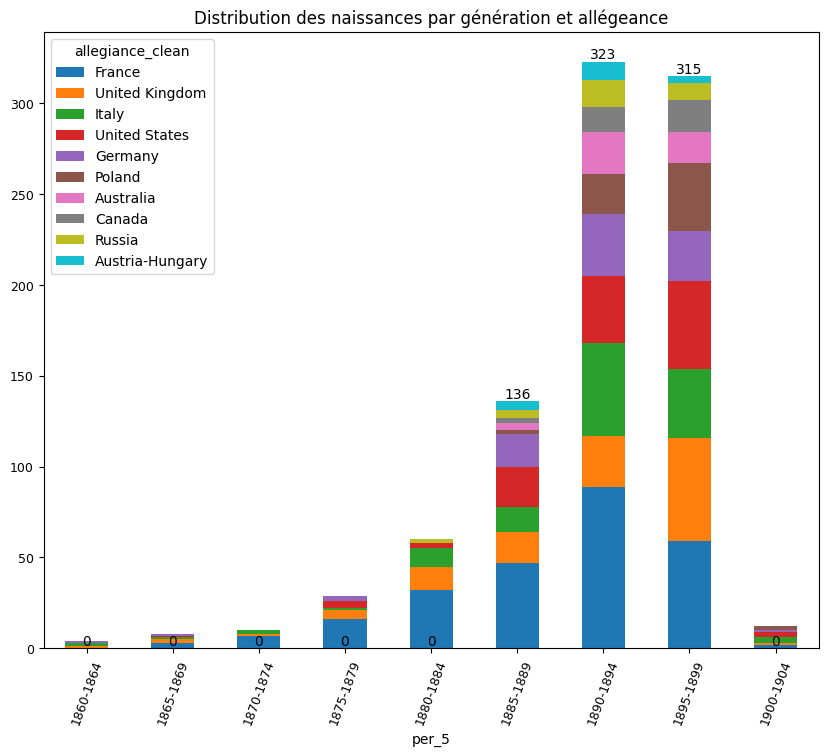

In [36]:
### Représenter l'évolution de la distribution dans le temps par continent
#  Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

data = ddf_top10.iloc[:-1,:-1]

ax = data.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8), 
                     color=col_palette_top10)
plt.title('Distribution des naissances par génération et allégeance')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()

## Analyse bivariée : périodes, allégeances



On observe un fort déséquilibre entre les périodes et les allégeances. Par exemple, on remarque que la France et le Royaume-Uni dominent largement les générations de pilotes nés entre 1880 et 1900. On observe aussi une montée en importance des États-Unis et une présence significative de l’Italie dans cette période.

En revanche, les Puissances centrales (Allemagne, Autriche-Hongrie) sont représentées mais avec des effectifs moindres.
La Pologne et la Russie sont présentes mais dans des proportions réduites.

Pour certains cas, les données sont loin d'être suffisantes; il faut donc restreindre. 



In [37]:
ddf

allegiance_clean,Argentina,Australia,Austria-Hungary,Belgium,Brazil,Bulgaria,Canada,Chile,Costa Rica,Czechoslovakia,...,Romania,Russia,Serbia,South Africa,Sweden,United Kingdom,United States,Venezuela,Wales,Total
per_5,,,,,,,,,,,,,,,,,,,,,
1860-1864,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,4
1865-1869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,1,0,0,9
1870-1874,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,11
1875-1879,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,5,4,0,0,31
1880-1884,1,0,0,1,1,0,0,0,0,0,...,0,2,0,0,0,13,3,0,0,68
1885-1889,0,4,5,2,0,2,3,0,0,0,...,1,4,0,0,1,17,22,1,0,148
1890-1894,0,23,10,4,0,2,14,0,1,1,...,3,15,1,3,1,28,37,0,1,347
1895-1899,0,17,4,2,0,1,18,0,0,0,...,0,9,0,1,0,57,48,0,0,327
1900-1904,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,3,0,0,12


In [38]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération

# Production du tableau à analyser (restreint aux top 10)
top10 = df['allegiance_clean'].value_counts().head(10).index.tolist()

df_top10 = df[df['allegiance_clean'].isin(top10)]

X = "allegiance_clean"
Y = "per_5"

D = df_top10[[X, Y]].pivot_table(
    index=Y,
    columns=X,
    observed=True,
    aggfunc=len,
).fillna(0).astype(int)

D



allegiance_clean,Australia,Austria-Hungary,Canada,France,Germany,Italy,Poland,Russia,United Kingdom,United States
per_5,,,,,,,,,,
1860-1864,0,0,0,0,1,2,0,0,1,0
1865-1869,0,0,0,3,1,1,0,0,2,1
1870-1874,0,0,0,7,0,2,0,0,1,0
1875-1879,0,0,0,16,3,1,0,0,5,4
1880-1884,0,0,0,32,0,10,0,2,13,3
1885-1889,4,5,3,47,18,14,2,4,17,22
1890-1894,23,10,14,89,34,51,22,15,28,37
1895-1899,17,4,18,59,28,38,37,9,57,48
1900-1904,0,0,0,2,1,3,2,0,1,3


In [39]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 9 , 10 ), effectif: 897 , nombre max. facteurs: 8


In [40]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 140.46 , dof : 72
p-value : 2.525799506548954e-06
phi2 = inertie (variance totale) : 0.15658672936652834
Cramer:  0.13990475749886436


In [41]:
### Situation à l'indépendance

indep = pd.DataFrame(expected)
indep.columns = D.columns
indep.index = D.index
indep.round(0).astype(int)

allegiance_clean,Australia,Austria-Hungary,Canada,France,Germany,Italy,Poland,Russia,United Kingdom,United States
per_5,,,,,,,,,,
1860-1864,0,0,0,1,0,1,0,0,1,1
1865-1869,0,0,0,2,1,1,1,0,1,1
1870-1874,0,0,0,3,1,1,1,0,1,1
1875-1879,1,1,1,8,3,4,2,1,4,4
1880-1884,3,1,2,17,6,8,4,2,8,8
1885-1889,7,3,5,39,13,18,10,5,19,18
1890-1894,16,7,13,92,31,44,23,11,45,42
1895-1899,15,7,12,90,30,43,22,11,44,41
1900-1904,1,0,0,3,1,2,1,0,2,2


In [42]:
D

allegiance_clean,Australia,Austria-Hungary,Canada,France,Germany,Italy,Poland,Russia,United Kingdom,United States
per_5,,,,,,,,,,
1860-1864,0,0,0,0,1,2,0,0,1,0
1865-1869,0,0,0,3,1,1,0,0,2,1
1870-1874,0,0,0,7,0,2,0,0,1,0
1875-1879,0,0,0,16,3,1,0,0,5,4
1880-1884,0,0,0,32,0,10,0,2,13,3
1885-1889,4,5,3,47,18,14,2,4,17,22
1890-1894,23,10,14,89,34,51,22,15,28,37
1895-1899,17,4,18,59,28,38,37,9,57,48
1900-1904,0,0,0,2,1,3,2,0,1,3


In [43]:


### Écart à l'indépendance:
# différence en effectifs entre le théorique et l'observé
#  Valeurs arrondies
### Doc. :
#   Bennani, p.30
#  https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4775616-analysez-deux-variables-qualitatives-avec-le-chi-2
ecarts = (D-indep)
## Attention : arrondi aux entiers dans l'affichage
print(ecarts.round(0).astype(int))



allegiance_clean  Australia  Austria-Hungary  Canada  France  Germany  Italy  \
per_5                                                                          
1860-1864                 0                0       0      -1        1      1   
1865-1869                 0                0       0       1        0      0   
1870-1874                 0                0       0       4       -1      1   
1875-1879                -1               -1      -1       8        0     -3   
1880-1884                -3               -1      -2      15       -6      2   
1885-1889                -3                2      -2       8        5     -4   
1890-1894                 7                3       1      -3        3      7   
1895-1899                 2               -3       6     -31       -2     -5   
1900-1904                -1                0       0      -1        0      1   

allegiance_clean  Poland  Russia  United Kingdom  United States  
per_5                                                

In [44]:


### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
residus_ponderes



allegiance_clean,Australia,Austria-Hungary,Canada,France,Germany,Italy,Poland,Russia,United Kingdom,United States
per_5,,,,,,,,,,
1860-1864,-0.44,-0.29,-0.40,-1.07,1.00,1.97,-0.53,-0.37,0.59,-0.73
1865-1869,-0.63,-0.41,-0.56,0.48,0.27,-0.08,-0.75,-0.52,0.84,-0.05
1870-1874,-0.70,-0.46,-0.62,2.47,-0.98,0.55,-0.84,-0.58,-0.33,-1.15
1875-1879,-1.19,-0.78,-1.06,2.70,0.13,-1.48,-1.43,-0.98,0.48,0.09
1880-1884,-1.72,-1.13,-1.53,3.62,-2.40,0.64,-2.05,-0.00,1.60,-1.74
1885-1889,-1.03,1.25,-1.00,1.34,1.37,-1.05,-2.44,-0.26,-0.45,0.97
1890-1894,1.80,1.21,0.39,-0.29,0.54,1.07,-0.14,1.28,-2.54,-0.84
1895-1899,0.39,-1.03,1.63,-3.23,-0.40,-0.74,3.16,-0.47,1.98,1.02
1900-1904,-0.77,-0.50,-0.68,-0.76,-0.14,1.07,1.26,-0.63,-0.52,1.13


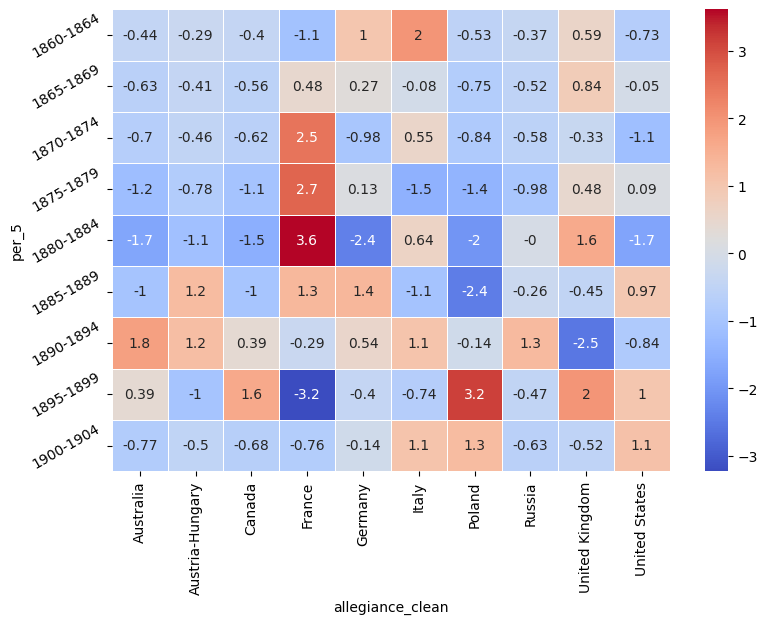

In [ ]:
### Résidus pondérés
tableau = residus_ponderes

fig, ax = plt.subplots(figsize=(9,6))         
# Sample figsize in inches
g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
labels = tableau.index
p = g.set_yticklabels(labels, rotation=30)

plt.savefig('heatmap_periods_allegeances.jpg', bbox_inches='tight', pad_inches=0.2)
plt.show()



La carte thermique présente la répartition des cohortes de naissance des pilotes parmi les dix principales allégeances.  
Les cases rouges indiquent une surreprésentation de pilotes par rapport aux attentes, tandis que les cases bleues signalent une sous-représentation.  
On remarque par exemple une forte présence de pilotes français nés entre 1880 et 1884, alors que d’autres pays apparaissent moins représentés à la même période.  
Cette visualisation met ainsi en évidence des différences générationnelles dans la distribution des pilotes selon les nations.


### En regroupant par bloc d'alliance

In [46]:
# Tableau par période × bloc d'alliance
X = "allianceBlock"
Y = "per_5"

D_blocks = df[[X, Y]].pivot_table(
    index=Y,
    columns=X,
    observed=True,
    aggfunc=len
).fillna(0).astype(int)

print(D_blocks.columns.to_list())
D_blocks

['Allies', 'Autre', 'Central Powers']


allianceBlock,Allies,Autre,Central Powers
per_5,,,
1860-1864,3,0,1
1865-1869,7,0,2
1870-1874,10,0,1
1875-1879,26,1,4
1880-1884,64,3,1
1885-1889,116,7,25
1890-1894,271,26,50
1895-1899,253,38,36
1900-1904,9,2,1


In [47]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D.iloc[ : , 1:])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[ : , 1:], method='cramer')
print('Cramer: ', vc)

Chi2 : 125.98 , dof : 64
p-value : 6.147137635578974e-06
phi2 = inertie (variance totale) : 0.14044689096481472
Cramer:  0.1358728788753242


In [48]:
D_blocks[['Allies', 'Central Powers', 'Autre']]

allianceBlock,Allies,Central Powers,Autre
per_5,,,
1860-1864,3,1,0
1865-1869,7,2,0
1870-1874,10,1,0
1875-1879,26,4,1
1880-1884,64,1,3
1885-1889,116,25,7
1890-1894,271,50,26
1895-1899,253,36,38
1900-1904,9,1,2


In [49]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D_blocks[['Allies', 'Central Powers']])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D_blocks[['Allies', 'Central Powers']], method='cramer')
print('Cramer: ', vc)

Chi2 : 12.66 , dof : 8
p-value : 0.12397199188774594
phi2 = inertie (variance totale) : 0.014117376476976378
Cramer:  0.11995873674957706


## Blocs d'alliance et décorations

In [50]:
df.head()

,aceUri,aceLabel,allegiance,nbAwards,birthYear,hasAward,allegiance_clean,allianceBlock,per_5
0,http://www.wikidata.org/entity/Q6225085,John Capper,United Kingdom of Great Britain and Ireland,2,1861,Oui,United Kingdom,Allies,1860-1864
1,http://www.wikidata.org/entity/Q3724015,Emanuele Vittorio Parodi,Kingdom of Italy,0,1862,Non,Italy,Allies,1860-1864
2,http://www.wikidata.org/entity/Q57569,Prince Henry of Prussia,Germany,11,1862,Oui,Germany,Central Powers,1860-1864
3,http://www.wikidata.org/entity/Q193236,Gabriele D'Annunzio,Kingdom of Italy,7,1863,Oui,Italy,Allies,1860-1864
4,http://www.wikidata.org/entity/Q1337203,Emile Reymond,France,2,1865,Oui,France,Allies,1865-1869


In [51]:

# tableau de contingence

X = "allianceBlock"
Y = "hasAward"

df_award = df[df[Y].isin(["Oui", "Non"])][[X, Y]]

contingency_award = df_award.pivot_table(
    index=Y,
    columns=X,
    observed=True,
    aggfunc=len,
    margins=True,
    margins_name="Total"
).fillna(0).astype(int)

contingency_award



allianceBlock,Allies,Autre,Central Powers,Total
hasAward,,,,
Non,163,8,47,218
Oui,596,69,74,739
Total,759,77,121,957


### Créer la fonction

In [52]:
def bivariee_stats(D):
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)


    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(D, method='cramer')
    print('Cramer: ', vc)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes

    fig, ax = plt.subplots(figsize=(9,3))         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

In [53]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = contingency_award.iloc[:-1, :-1].copy(deep=True)
D



allianceBlock,Allies,Autre,Central Powers
hasAward,,,
Non,163,8,47
Oui,596,69,74


Chi2 : 25.2 , dof : 2
p-value : 3.3673158381178896e-06
phi2 = inertie (variance totale) : 0.028096755001493515
Cramer:  0.16228124649441883


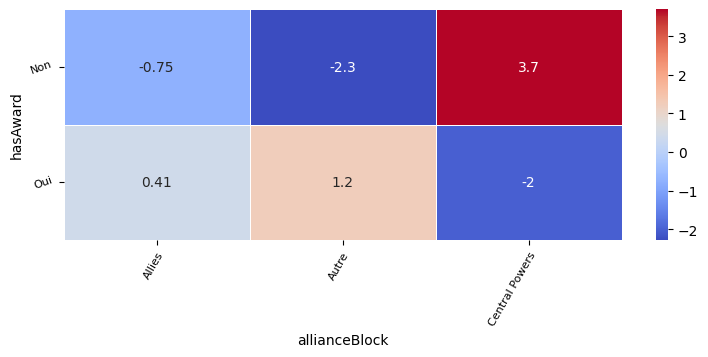

In [54]:
bivariee_stats(D)

### Décorations et alliance par période

In [55]:
df['block_award'] = df.apply(lambda x: x['allianceBlock'] + '_' + x['hasAward'], axis=1)
df.head()

,aceUri,aceLabel,allegiance,nbAwards,birthYear,hasAward,allegiance_clean,allianceBlock,per_5,block_award
0,http://www.wikidata.org/entity/Q6225085,John Capper,United Kingdom of Great Britain and Ireland,2,1861,Oui,United Kingdom,Allies,1860-1864,Allies_Oui
1,http://www.wikidata.org/entity/Q3724015,Emanuele Vittorio Parodi,Kingdom of Italy,0,1862,Non,Italy,Allies,1860-1864,Allies_Non
2,http://www.wikidata.org/entity/Q57569,Prince Henry of Prussia,Germany,11,1862,Oui,Germany,Central Powers,1860-1864,Central Powers_Oui
3,http://www.wikidata.org/entity/Q193236,Gabriele D'Annunzio,Kingdom of Italy,7,1863,Oui,Italy,Allies,1860-1864,Allies_Oui
4,http://www.wikidata.org/entity/Q1337203,Emile Reymond,France,2,1865,Oui,France,Allies,1865-1869,Allies_Oui


In [56]:
X = "block_award"
Y = "per_5"

df_award = df[df['hasAward'].isin(['Oui', 'Non']) & df['allianceBlock'].notna() & df['per_5'].notna()]

ddbap = df_award[[X, Y]].pivot_table(
    index=Y,
    columns=X,
    observed=True,
    aggfunc=len,
    margins=True,
    margins_name="Total"
).fillna(0).astype(int)

ddbap



block_award,Allies_Non,Allies_Oui,Autre_Non,Autre_Oui,Central Powers_Non,Central Powers_Oui,Total
per_5,,,,,,,
1860-1864,1,2,0,0,0,1,4
1865-1869,1,6,0,0,1,1,9
1870-1874,6,4,0,0,1,0,11
1875-1879,6,20,0,1,1,3,31
1880-1884,9,55,0,3,1,0,68
1885-1889,21,95,3,4,10,15,148
1890-1894,55,216,4,22,21,29,347
1895-1899,61,192,1,37,12,24,327
1900-1904,3,6,0,2,0,1,12


In [57]:
# limiter à la période significative
D = ddbap.iloc[4:-1, :-1].copy(deep=True)
D


block_award,Allies_Non,Allies_Oui,Autre_Non,Autre_Oui,Central Powers_Non,Central Powers_Oui
per_5,,,,,,
1880-1884,9,55,0,3,1,0
1885-1889,21,95,3,4,10,15
1890-1894,55,216,4,22,21,29
1895-1899,61,192,1,37,12,24
1900-1904,3,6,0,2,0,1


Chi2 : 37.2 , dof : 20
p-value : 0.011082588885817025
phi2 = inertie (variance totale) : 0.04146780567806642
Cramer:  0.10153563388403726


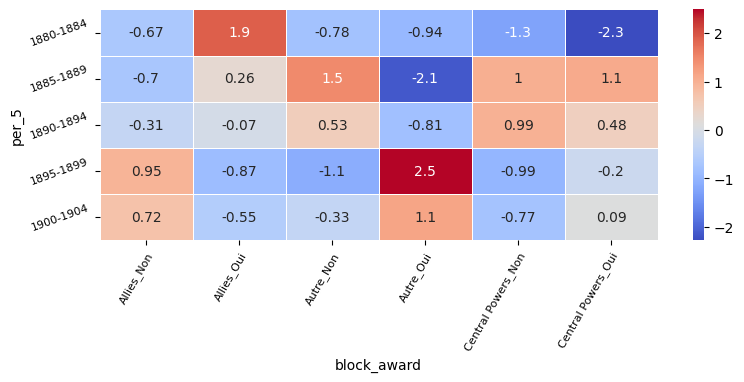

In [58]:
## Appliquer la fonction
bivariee_stats(D)

#### Explorer les résultats et commenter

In [59]:
df_ao = df[df['block_award'] == 'Autre_Oui']
print(len(df_ao))
df_ao.head()


69


,aceUri,aceLabel,allegiance,nbAwards,birthYear,hasAward,allegiance_clean,allianceBlock,per_5,block_award
48,http://www.wikidata.org/entity/Q246473,José Luis Sánchez Besa,Chile,3,1879,Oui,Chile,Autre,1875-1879,Autre_Oui
75,http://www.wikidata.org/entity/Q2701468,Prince Antônio Gastão of Brazil,Brazil,9,1881,Oui,Brazil,Autre,1880-1884,Autre_Oui
82,http://www.wikidata.org/entity/Q11564994,Kiyotake Shigeno,Japan,1,1882,Oui,Japan,Autre,1880-1884,Autre_Oui
87,http://www.wikidata.org/entity/Q3556915,Vicente Almandos Almonacid,Argentina,1,1882,Oui,Argentina,Autre,1880-1884,Autre_Oui
161,http://www.wikidata.org/entity/Q5982989,Luis Camilo Ramírez Rivas-Dávila,Venezuela,1,1886,Oui,Venezuela,Autre,1885-1889,Autre_Oui


In [60]:
## On observe la prédominance de la Pologne dans "Autre"
print(
    df_ao.groupby(by="allegiance_clean", observed=True)
         .size()
         .sort_values(ascending=False)
         .head(10)
)

allegiance_clean
Poland            59
Brazil             1
Argentina          1
Chile              1
Czechoslovakia     1
Mexico             1
Japan              1
Norway             1
Sweden             1
Venezuela          1
dtype: int64


In [61]:

print(
    df_ao[df_ao['per_5'] == '1895-1899']
      .groupby('allegiance_clean', observed=True)
      .size()
      .sort_values(ascending=False)
      .head(10)
)


allegiance_clean
Poland    36
Mexico     1
dtype: int64


In [62]:
fff = df_ao[
    (df_ao['per_5'] == '1895-1899')
    & (df_ao['allegiance_clean'].str.contains('Poland')) 
]
print(len(fff))
fff.head()


36


,aceUri,aceLabel,allegiance,nbAwards,birthYear,hasAward,allegiance_clean,allianceBlock,per_5,block_award
635,http://www.wikidata.org/entity/Q5649562,Hans-Georg von der Osten,Poland,1,1895,Oui,Poland,Autre,1895-1899,Autre_Oui
639,http://www.wikidata.org/entity/Q40331587,Franciszek Haberek,Second Polish Republic,2,1895,Oui,Poland,Autre,1895-1899,Autre_Oui
656,http://www.wikidata.org/entity/Q79054363,Edmund Norwid-Kudło,Second Polish Republic,6,1895,Oui,Poland,Autre,1895-1899,Autre_Oui
664,http://www.wikidata.org/entity/Q117360008,Bronisław Wąsowski,Poland,1,1895,Oui,Poland,Autre,1895-1899,Autre_Oui
667,http://www.wikidata.org/entity/Q85089729,Tomasz Turbiak,Poland,3,1895,Oui,Poland,Autre,1895-1899,Autre_Oui


## Version de Has award x Alliance block équilibrée

## Alliance block et award count
Pour mieux comprendre si un bloc d'alliance avait plus de chance d'être décoré, il est préférable d'équilibrer les échantillons. 

In [ ]:

df["block_award"] = df.apply(lambda x: f"{x['allianceBlock']}_{x['hasAward']}", axis=1)

df_award = df[
    df["hasAward"].isin(["Oui", "Non"]) &
    df["allianceBlock"].isin(["Allies", "Central Powers"]) &
    df["per_5"].notna()
].copy()

# 2) BALANCE Allies vs Central Powers at the pilot level (like your 121/121)
n_cp = df_award[df_award["allianceBlock"] == "Central Powers"].shape[0]  # e.g., 121
df_allies_bal = df_award[df_award["allianceBlock"] == "Allies"].sample(
    n=n_cp, random_state=42
)
df_cp = df_award[df_award["allianceBlock"] == "Central Powers"]
df_balanced = pd.concat([df_allies_bal, df_cp], ignore_index=True)

# (optional) Restrict to cohorts starting ≤ 1904
keep_mask = df_balanced["per_5"].astype(str).str[:4].astype(int) <= 1904
df_balanced = df_balanced[keep_mask]

# 3) Build the contingency table: per_5 × block_award (COUNTS of pilots)
X = "block_award"
Y = "per_5"
D_bal = df_balanced[[X, Y]].pivot_table(
    index=Y, columns=X, observed=True, aggfunc=len
).fillna(0).astype(int)

D_bal  # <- your balanced table (counts of pilots per cohort × block_award)


In [63]:
df.head()

,aceUri,aceLabel,allegiance,nbAwards,birthYear,hasAward,allegiance_clean,allianceBlock,per_5,block_award
0,http://www.wikidata.org/entity/Q6225085,John Capper,United Kingdom of Great Britain and Ireland,2,1861,Oui,United Kingdom,Allies,1860-1864,Allies_Oui
1,http://www.wikidata.org/entity/Q3724015,Emanuele Vittorio Parodi,Kingdom of Italy,0,1862,Non,Italy,Allies,1860-1864,Allies_Non
2,http://www.wikidata.org/entity/Q57569,Prince Henry of Prussia,Germany,11,1862,Oui,Germany,Central Powers,1860-1864,Central Powers_Oui
3,http://www.wikidata.org/entity/Q193236,Gabriele D'Annunzio,Kingdom of Italy,7,1863,Oui,Italy,Allies,1860-1864,Allies_Oui
4,http://www.wikidata.org/entity/Q1337203,Emile Reymond,France,2,1865,Oui,France,Allies,1865-1869,Allies_Oui


In [64]:
df.groupby('allianceBlock').size()


allianceBlock
Allies            759
Autre              77
Central Powers    121
dtype: int64

In [86]:
# On inspect d'abord nbAwards: il s'agit d'un object et pas un int. 
df['nbAwards'].dtype


dtype('int64')

In [87]:
# on résout le problème
df['nbAwards'] = pd.to_numeric(df['nbAwards'], errors='coerce')
df['nbAwards'] = df['nbAwards'].fillna(0).astype(int)


In [88]:
# on groupe les awards par alliance, vérifie que l'on a bien des entiers. 
df.groupby('allianceBlock')['nbAwards'].sum()


allianceBlock
Allies            1664
Autre              260
Central Powers     237
Name: nbAwards, dtype: int64

Le déséquilibre est trop important entre le nombre de pilotes alliés et des pouvoirs centraux. Sans surprise cela risque de largement fausser les analyses. On se penche donc plutôt sur la moyenne de awards par pilote. La cellule 76 a démontré que nous avons 121 pilotes des puissances centrales pour 759 alliés. 

In [89]:
# Filter if needed (e.g. just Allies and Central Powers)
df_aw = df[df['allianceBlock'].isin(['Allies', 'Central Powers'])].copy()

# Make sure nbAwards is numeric
df_aw['nbAwards'] = pd.to_numeric(df_aw['nbAwards'], errors='coerce').fillna(0)

# Group by alliance block and compute average
avg_awards = df_aw.groupby('allianceBlock')['nbAwards'].mean().round(2)

print(avg_awards)

allianceBlock
Allies            2.19
Central Powers    1.96
Name: nbAwards, dtype: float64


In [95]:
# on ajoute la période
df_aw['per_5'] = df_aw['per_5'].cat.remove_unused_categories()
df_aw.groupby(['allianceBlock', 'per_5'])['nbAwards'].mean().unstack(fill_value=0).round(2)


C:\Users\menou\AppData\Local\Temp\ipykernel_17760\3793405197.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_aw.groupby(['allianceBlock', 'per_5'])['nbAwards'].mean().unstack(fill_value=0).round(2)


per_5,1860-1864,1865-1869,1870-1874,1875-1879,1880-1884,1885-1889,1890-1894,1895-1899,1900-1904
allianceBlock,,,,,,,,,
Allies,3.0,2.14,1.9,1.96,2.59,2.41,2.14,2.11,1.0
Central Powers,11.0,0.50,0.0,4.00,0.00,2.12,1.58,1.92,8.0


In [ ]:
# on normalize en pourcentage
df_awards_avg = df_aw.groupby(['per_5', 'allianceBlock'])['nbAwards'].mean().unstack(fill_value=0).round(2)
df_awards_profiles = df_awards_avg.apply(lambda x: (x / sum(x) * 100).round(1), axis=1)
df_awards_profiles


C:\Users\menou\AppData\Local\Temp\ipykernel_17760\1066853147.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_awards_avg = df_aw.groupby(['per_5', 'allianceBlock'])['nbAwards'].mean().unstack(fill_value=0).round(2)


allianceBlock,Allies,Central Powers
per_5,,
1860-1864,21.4,78.6
1865-1869,81.1,18.9
1870-1874,100.0,0.0
1875-1879,32.9,67.1
1880-1884,100.0,0.0
1885-1889,53.2,46.8
1890-1894,57.5,42.5
1895-1899,52.4,47.6
1900-1904,11.1,88.9


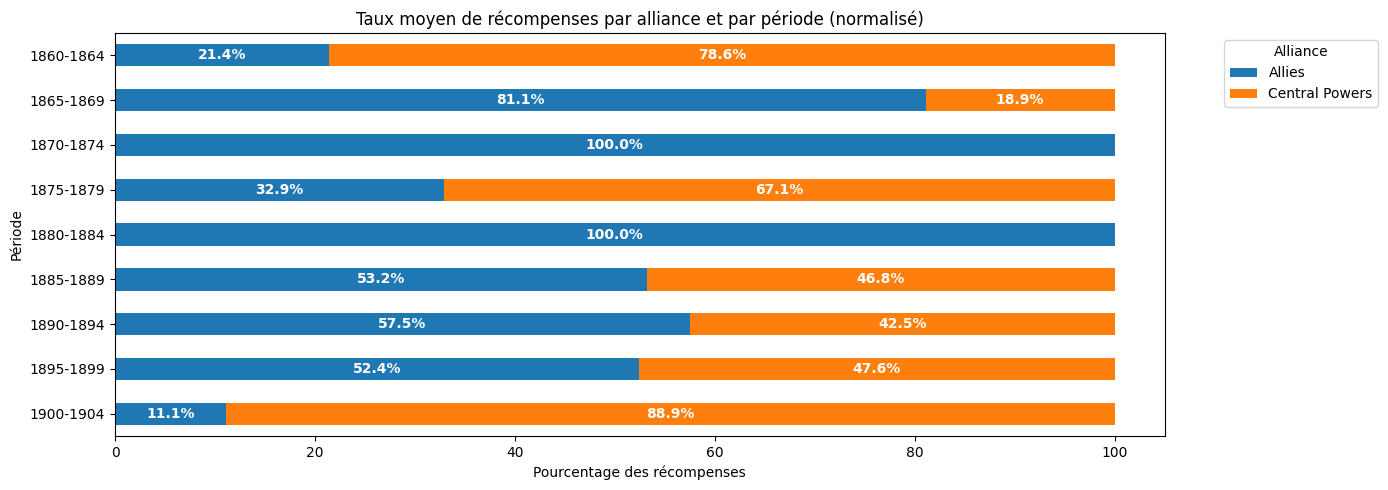

In [99]:
col_palette_2 = [
    "#1f77b4",  # Allies - blue
    "#ff7f0e"   # Central Powers - orange
]

ax = df_awards_profiles.sort_index(ascending=False).plot(
    kind="barh",
    stacked=True,
    figsize=(14, 5),
    title='Taux moyen de récompenses par alliance et par période (normalisé)',
    color=col_palette_2
)

# Annotate bars
for p in ax.patches:
    width = p.get_width()
    if width > 5:
        ax.annotate(f"{width:.1f}%",
                    (p.get_x() + width / 2, p.get_y() + p.get_height() / 2),
                    ha='center', va='center',
                    color='white', weight='bold', fontsize=10)

ax.set_xlabel("Pourcentage des récompenses")
ax.set_ylabel("Période")
ax.legend(title="Alliance", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Étant donné qu’il s’agit ici de pourcentages ou de moyennes, on ne peut pas effectuer un test du chi² ni construire un tableau de contingence, car ces méthodes nécessitent des données brutes et entières. Le principal problème vient du déséquilibre important entre le nombre de pilotes Alliés et celui des Puissances centrales. Pour l’exercice, on extrait donc un échantillon aléatoire de 121 pilotes Alliés afin d’obtenir un effectif équivalent à celui des Puissances centrales. Évidemment, les résultats sur un total de 242 individus resteront limités en termes de portée statistique.

In [ ]:
### Tableau des récompenses par période de naissance (5 ans) et bloc d’alliance, après échantillonnage équilibré


df_allies = df[df['allianceBlock'] == 'Allies']
df_central = df[df['allianceBlock'] == 'Central Powers']

df_allies_sampled = df_allies.sample(n=121, random_state=42)

df_sampled = pd.concat([df_allies_sampled, df_central]).reset_index(drop=True)

# Construire tableau de contingence
df_counts_sampled = df_sampled.groupby(['per_5', 'allianceBlock'])['nbAwards'].sum().unstack(fill_value=0).astype(int)

# Filtrer pour ne garder que les périodes commençant avant ou en 1904
df_counts_sampled = df_counts_sampled[df_counts_sampled.index.astype(str).str[:4].astype(int) <= 1904]

D = df_counts_sampled
D



C:\Users\menou\AppData\Local\Temp\ipykernel_17760\3348601339.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_counts_sampled = df_sampled.groupby(['per_5', 'allianceBlock'])['nbAwards'].sum().unstack(fill_value=0).astype(int)


allianceBlock,Allies,Central Powers
per_5,,
1860-1864,7,11
1865-1869,6,1
1870-1874,0,0
1875-1879,8,16
1880-1884,44,0
1885-1889,37,53
1890-1894,93,79
1895-1899,84,69
1900-1904,1,8


Chi2 : 18.02 , dof : 6
p-value : 0.0061725897676253106
phi2 = inertie (variance totale) : 0.020093603714121278
Cramer:  0.195206631626071


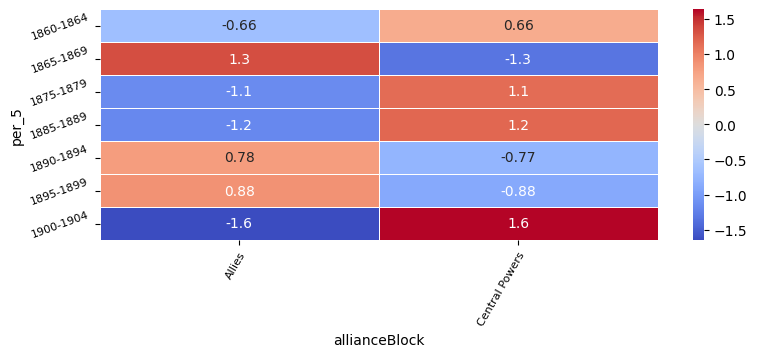

In [112]:
## Appliquer la fonction
# etant donné que certaines rangées ont 0, on s'en débarasse, autrement pas de test de chi2
D_clean = D[(D > 0).all(axis=1)]
bivariee_stats(D_clean)

Le test du chi² (χ² = 18.02, ddl = 6, p = 0.006) montre que la répartition des récompenses entre Alliés et Puissances centrales varie de manière significative selon la période. L’intensité de l’association est toutefois faible à modérée (V de Cramér ≈ 0.20), ce qui suggère que si la période influence la distribution des récompenses, cet effet reste limité.

ATTENTION, ici il s'agit juste d'un test pour avoir une idée des effets. Un test CHI2 s'applique à des variables qualitatives et pas des effectifs, il s'agit donc surtout d'une erreur dans l'exercice. ON n'en retire donc aucune conclusion. 